In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json


import platform

import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import nltk
import re
from tabulate import tabulate
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

!pip install transformers
import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os = platform.system()

match os.lower():
    case "darwin":
        path = "/Users/antoniobaio/Desktop/Progetti/ProgettiDS/BERT"
    case "linux":
        path = "/home/antonio/Scrivania/ProgettiDS/BERT"
    case "windows":
        path = "AGGIUNGI PATH"
        
print("Actual path: " + path + " and device = " + str(device))

In [24]:
#from google.colab import drive
#drive.mount('/content/drive')

In [25]:
df = pd.read_csv(f"{path} + movie.csv")
df['label'] = df['label'].astype(int)
df = df.sample(n=20000, random_state=42)

df

,text,label
32823,The central theme in this movie seems to be co...,0
16298,"An excellent example of ""cowboy noir"", as it's...",1
28505,The ending made my heart jump up into my throa...,0
6689,Only the chosen ones will appreciate the quali...,1
26893,"This is a really funny film, especially the se...",1
...,...,...
14965,"When I was very young, my mother had a series ...",1
22133,Hello Mary Lou: Prom Night II starts at the Ha...,0
5442,This is a really really bad movie. That may se...,0
21456,I checked this movie out based on a favorable ...,0


In [26]:
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

df['text'] = df['text'].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


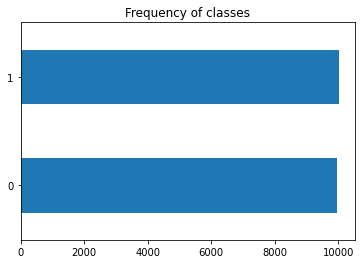

In [27]:
df['label'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.show()

In [28]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print("Dimensioni del set di training:", len(train_df))
print("Dimensioni del set di test:", len(test_df))


Dimensioni del set di training: 14000
Dimensioni del set di test: 6000


In [29]:
sentences = train_df.text
labels = list(train_df.label)

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [31]:
MAX_LEN = 512
#Tokenizza tutte le frasi e mappa i tokens con i loro IDs
input_ids = []
attention_masks = []

for sent in sentences:
    # Quello che `encode_plus` farà:
    #   1. Tokenizza la frase
    #   2. Aggiunge il token `[CLS]` all'inizio della frase
    #   3. Aggiunge il token `[SEP]` alla fine della frase
    #   4. Mappa il token con il loro ID
    #   5. Esegue il padding o tronca la frase affinche la sua lunghezza sia pari a `max_length`
    #   6. Crea le attention masks per il token [PAD]
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,      #Aggiunge i tokens '[CLS]' e '[SEP]'
                        max_length = MAX_LEN,           #Setta la lunghezza massima
                        pad_to_max_length = True,       #Se necessaio esegue il padding
                        return_attention_mask = True,   #Costruisce le attn. masks
                        return_tensors = 'pt',          #Restituisce un tensore di pytorch
                   )
    
    #Aggiunge la frase codificata alla lista degli input   
    input_ids.append(encoded_dict['input_ids'])
    
    #E aggiunge le attention mask alla lista (semplice distinzione tra padding o meno)
    attention_masks.append(encoded_dict['attention_mask'])

#Converte la lista in un tensore
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
#Stampa la prima frase come una lista di IDs
i=random.randint(0,len(sentences)-1)
print('Original: ', list(sentences)[i])
print('Input IDs:', input_ids[i])

Original:  awesome amicus horror anthology, great stories, fantastic performances, last story disappoints characters awesome, film quite chilling suspenseful, plus peter cushing christopher lee simply amazing underrated favorite story rd one sweets sweet , plus characters likable predictable, last story incredibly disappointing rather bland, however ending really cool awesome amicus horror anthology, great stories, fantastic performances, last story disappoints, say must see br br st story method murder awesome story, plenty suspense, killer dominic really creepy, well acted well perfect way start story, part unpredictable, plus double twist ending shocking, quite creepy grade br br nd story waxworks solid story around, wonderful performances, however ending quite predictable, still creepy, quite bit suspense, peter cushing amazing job, believe young joss ackland was, really enjoyed story grade b br br rd story sweets sweet best story here, extremely creepy, unpredictable throughout, a

In [33]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random sentences sample'''
  index = random.randint(0, len(sentences) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(list(sentences)[index])
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

start confessing tend really enjoy action movies military guy dreck awful saw free, showtime hbo still feel paid much prolonged episode general hospital br br gave , possible others would give rating boggles mind unless family cast crew br br might be, movie bad many bailed outand such, uninvested bother br br sorry repeating line minimum seems silly, essentially boils warningin hopes saving others hr black hole, movie represents trust me, stare blank wall, action
╒═════════════╤═════════════╤══════════════════╕
│ Tokens      │   Token IDs │   Attention Mask │
╞═════════════╪═════════════╪══════════════════╡
│ [CLS]       │         101 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ start       │        2707 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ confess     │       18766 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ##ing       │        2075 │                1 │
├─────────────┼─────────────┼────────────

In [34]:
#Creaun unico Dataset (di tensori) unendo i tensori relativi agli input, alle label e alle attention mask
dataset = TensorDataset(input_ids, attention_masks, labels)

#Creazione del training set e del validation set (80-20)

#Calcola il numero di elementi che dovrà essere inserito in ciascun set
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size

#Divide randomicamente il dataset in training set e validation set
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

10,500 training samples
3,500 validation samples


In [35]:
#Per eseguire il fine-tuning di BERT su un task specifico, è raccomandata una dimensione del batch pari a 16 o a 32
batch_size = 16

#Crea il DataLoaders per il training set e per il validation set
#Vengono presi gli elementoi del training set in ordine randomico
train_dataloader = DataLoader(
            train_dataset,  #Il training set
            sampler = RandomSampler(train_dataset), #Seleziona randomicamente i batch
            batch_size = batch_size #Esegue l'allenamento con questa dimensione dei batch
        )


validation_dataloader = DataLoader(
            val_dataset, #Il validation set
            sampler = SequentialSampler(val_dataset), #Seleziona i batch in maniera sequenziale
            batch_size = batch_size #Esegue una valutazione del modello con questa dimensione dei batch
        )

In [36]:
# Viene caricato il modello pre-allenato BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #Usa il modello di BERT a 12-layer con un vocabolario tutto in lower case
    num_labels = 6, #Il numero delle label 
    output_attentions = False,
    output_hidden_states = False,
)

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [37]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning_rate - quello standard è 5e-5
                  eps = 1e-8 # adam_epsilon  - quello standard è 1e-8.
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
epochs = 2

#Numero totale degli step di training, è dato da: [numero di batch] x [numero di epoche]
total_steps = len(train_dataloader) * epochs

#Viene creato lo scheduler del learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [39]:
#Funzione per calcolare l'accuratezza della nostra predizione (rispetto alla label)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [40]:
#Funzione che formatta il tempo arrotondando i secondi e dandogli il pattern hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [41]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

#Misura il tempo totale che è stato necessario per il training
total_t0 = time.time()

for epoch_i in range(0, epochs):
    #               Training
    #Esegue un primo passo (completo) nel training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    #Misura quanto ci mette l'epoca in questione
    t0 = time.time()
    total_train_loss = 0

    #Mette il modello in training mode (presta attenzione al fatto che NON esegue l'allenamento del modello)
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #Pulisce i gradienti precedentemente clacolati prima di eseguire un backward 
        #pass (PyTorch non lo fa di default perchè nell'allenamento di RNN è conveniente accumularli)
        model.zero_grad()
        #La documentazione relativa al modello la si può trovare al link sotto:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        #Ritorna un numero differente di parametri in base in base agli argomenti dati e alle flag settate.
        # Nel nostro caso ritorna la loss (perchè abbiamo dato un dataset etichettato in input)
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)  
        #Accumula la loss di allenamento su tutti i batch in modo da poter calcolare la perdita 
        #media alla fine. `loss` è un tensore contenente un singolo valore;                          
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        #Esegue un backward pass per calcolare i gradienti
        loss.backward()
        #Ritaglia la norma dei gradienti a 1.0.
        #Questo per aiutare a prevenire il problema dei "gradienti che esplodono".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #Aggiorna i parametri e fa uno step usando il gradiente calcolato.
        #L'ottimizzatore detta la "regola di aggiornamento": come i parametri 
        #vengono modificati in base ai loro gradienti, al tasso di apprendimento, ecc.
        optimizer.step()
        #Aggiorna il learning rate
        scheduler.step()

    #Calcola la perdita media di tutti i batch
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    #Misura quanto tempo è necessario per questa epoca
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    #               Validation
    #Dopo il completamento di ogni epoca di addestramento, misurariamo
    # le nostre prestazioni sul nostro set di convalida.
    print("")
    print("Running Validation...")

    t0 = time.time()

    #Mette il modello nel mode di valutazione

    model.eval()

    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    #Valuta i dati di una epoca
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Dice a pytorch di non preoccuparsi di costruire il compute graph durante il passaggio 
        #in avanti, poiché questo è necessario solo per il backprop (fase di addestramento).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        #Sposta i logits e le labels sulla CPU se stavamo usando la GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Calcola l'accuratezza per questo batch di test, e la accumula con quella di ogni batch
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    #Restituisce l'accuratezza
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #Restituise la loss media
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    #Misura quanto tempo c'è voluto per la validazione
    validation_time = format_time(time.time() - t0)

    #Salva il modello migliore
    if avg_val_accuracy < best_eval_accuracy:
        torch.save(model, '/content/drive/MyDrive/BERT/bert_model_bbc')
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    #Memorizza tutte le statistiche per questa epoca
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    json_file = "/content/drive/MyDrive/BERT/training_stats.json"

    with open(json_file, 'w') as outfile:
        json.dump(training_stats, outfile)

print("")
print("Training complete!")
print(training_stats)

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.38
  Training epoch took: 0:16:25

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.28
  Validation took: 0:02:02

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.19
  Training epoch took: 0:16:28

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.32
  Validation took: 0:02:02

Training complete!
[{'epoch': 1, 'Training Loss': 0.38172496821521534, 'Valid. Loss': 0.2763461714618963, 'Valid. Accur.': 0.8870814307458144, 'Training Time': '0:16:25', 'Validation Time': '0:02:02'}, {'epoch': 2, 'Training Loss': 0.18844016191026527, 'Valid. Loss': 0.3221941561199997, 'Valid. Accur.': 0.8940258751902587, 'Training Time': '0:16:28', 'Validation Time': '0:02:02'}]
Total training took 0:37:00 (h:mm:ss)


In [42]:
#Per i numeri float, mette due decimali dopo la virgola
display.precision = 2
#Crea un DataFrame per le nostre statistiche di allenamento
df_stats = pd.DataFrame(data=training_stats)

#Usa il numero dell'epoca come indice della riga
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.381725,0.276346,0.887081,0:16:25,0:02:02
2,0.188440,0.322194,0.894026,0:16:28,0:02:02


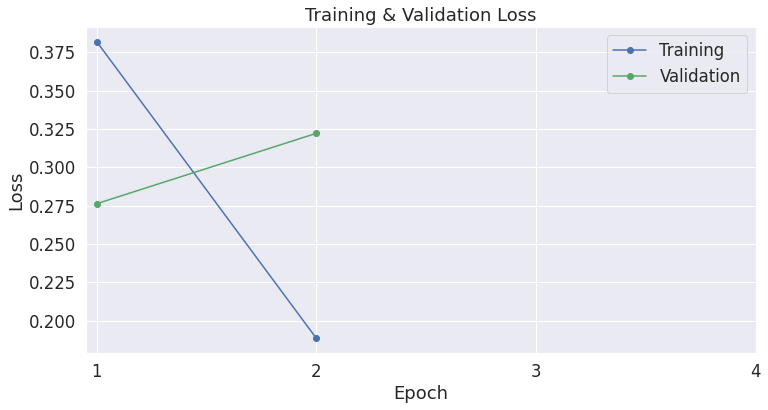

In [43]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

#Stampa la learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [44]:
model = torch.load('/Users/antoniobaio/Desktop/Progetti/ProgettiDS/BERT/bert_model_bbc')

In [45]:
# Create sentence and label lists
sentences = test_df.text.values
labels = test_df.label.values

MAX_LEN = 512
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [46]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 6,000 test sentences...
    DONE.


In [47]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import accuracy_score
accuracy_score(scores, labels)

0.8981666666666667

In [48]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

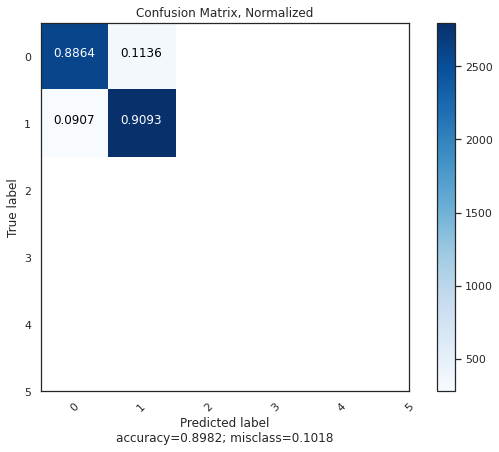

In [49]:
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['0', '1', '2','3','4','5'],
                      title        = "Confusion Matrix, Normalized")